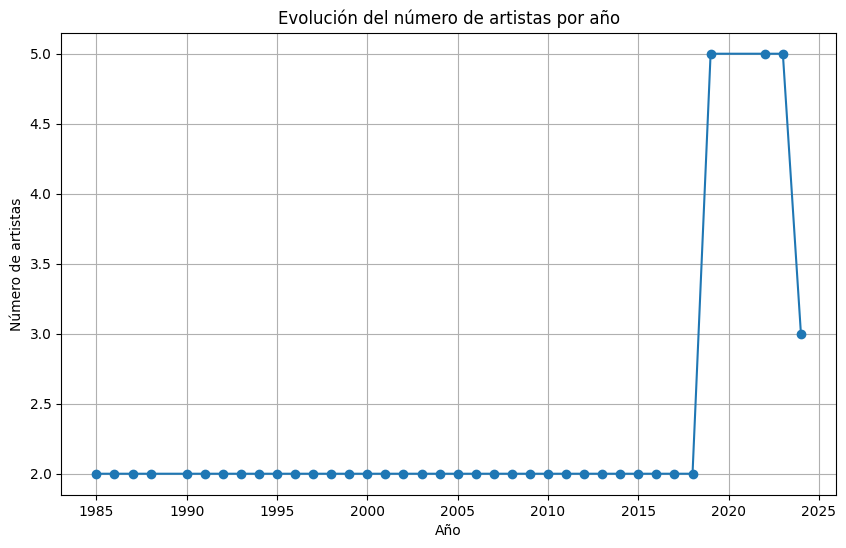

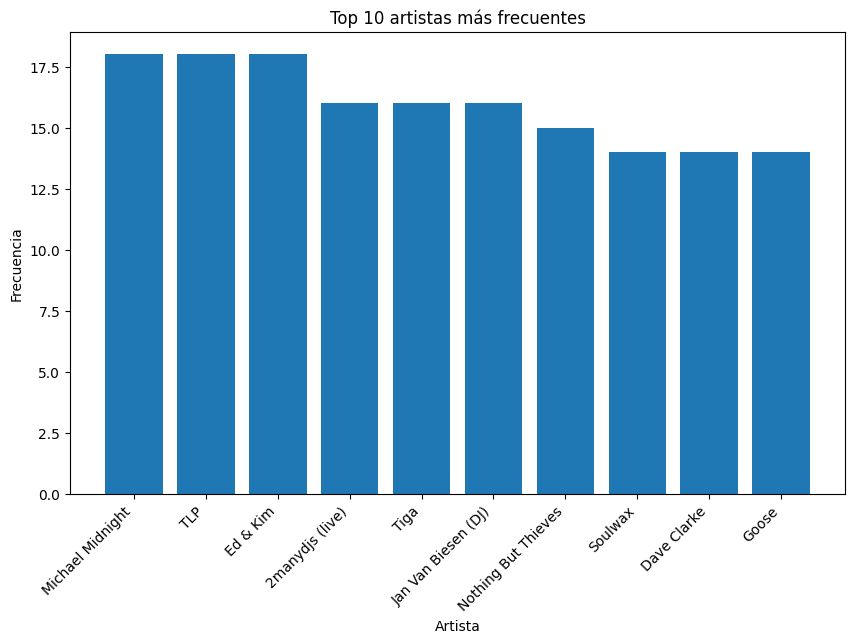

Resumen generado y guardado como './results\festival_analysis_summary.md'.


In [ ]:
# Importar librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import json

# Cargar datos desde archivos JSON
cleaned_data_path = '../data/cleaned_festivals_data.json'
festivals_data_path = '../data/festivals_data.json'
werchter_data_path = '../data/werchter_data.json'

# Cargar archivos JSON
with open(cleaned_data_path, 'r') as file:
    cleaned_festivals_data = json.load(file)

with open(festivals_data_path, 'r') as file:
    festivals_data = json.load(file)

with open(werchter_data_path, 'r') as file:
    werchter_data = json.load(file)

# Convertir datos a DataFrame
cleaned_festivals_df = pd.DataFrame([
    {"festival": fest, "year": year, "artists": artists}
    for fest, years in cleaned_festivals_data.items()
    for year, artists in years.items()
])

festivals_df = pd.DataFrame([
    {"festival": fest, "year": year, "artists": artists}
    for fest, years in festivals_data.items()
    for year, artists in years.items()
])

werchter_df = pd.DataFrame([
    {"festival": "Rock Werchter", "year": year, "artists": artists}
    for year, artists in werchter_data.items()
])

# Combinar todos los datos
combined_df = pd.concat([cleaned_festivals_df, festivals_df, werchter_df], ignore_index=True)

# Asegurar que los años sean numéricos
combined_df['year'] = pd.to_numeric(combined_df['year'], errors='coerce')

# Explode para separar artistas en filas individuales
combined_df['artists'] = combined_df['artists'].apply(lambda x: x if isinstance(x, list) else [])
exploded_df = combined_df.explode('artists').reset_index(drop=True)

# Análisis
# 1. Festival con la historia más larga de operación continua
festival_years = combined_df.groupby('festival')['year'].agg(['min', 'max']).reset_index()
festival_years['duration'] = festival_years['max'] - festival_years['min'] + 1
longest_running_festival = festival_years.sort_values('duration', ascending=False).iloc[0]

# 2. Frecuencia de artistas
artist_frequency = exploded_df['artists'].value_counts().reset_index()
artist_frequency.columns = ['artist', 'frequency']
top_artists = artist_frequency.head(10)

# 3. Evolución del número de artistas por año
artists_per_year = combined_df.groupby('year').size().reset_index(name='artist_count')

# 4. Artistas presentes en múltiples festivales en el mismo año
multi_festival_artists = (
    exploded_df.groupby(['year', 'artists'])['festival']
    .nunique()
    .reset_index(name='festival_count')
    .query('festival_count > 1')
)

# 5. Headliners por año y festival
headliners = combined_df.groupby(['festival', 'year'])['artists'].apply(lambda x: x[:3]).reset_index()

# Visualizaciones
# Evolución del número de artistas por año
plt.figure(figsize=(10, 6))
plt.plot(artists_per_year['year'], artists_per_year['artist_count'], marker='o')
plt.title('Evolución del número de artistas por año')
plt.xlabel('Año')
plt.ylabel('Número de artistas')
plt.grid(True)
plt.show()

# Top 10 artistas más frecuentes
plt.figure(figsize=(10, 6))
plt.bar(top_artists['artist'], top_artists['frequency'])
plt.title('Top 10 artistas más frecuentes')
plt.xlabel('Artista')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')
plt.show()

# Generar el resumen Markdown con ajustes
markdown_summary = f"""
# Análisis de Festivales de Música

## 1. Festival con la historia más larga de operación continua
- **Festival**: {longest_running_festival['festival']}
- **Duración**: {longest_running_festival['duration']} años (de {longest_running_festival['min']} a {longest_running_festival['max']})

## 2. Artistas más frecuentes
### Los 10 artistas más frecuentes:
{top_artists.to_string(index=False)}

## 3. Evolución del número de artistas por año
Se observa un crecimiento constante en el número de artistas en los festivales a lo largo del tiempo.
Consulta el gráfico correspondiente para más detalles.

## 4. Artistas presentes en múltiples festivales
### Ejemplo de artistas que participaron en varios festivales en el mismo año:
{multi_festival_artists.head().to_string(index=False)}

## 5. Headliners por festival y año
### Ejemplo de headliners seleccionados:
{headliners.head().to_string(index=False)}

## Conclusión
El análisis muestra tendencias claras de expansión en los festivales de música y la importancia de ciertos artistas destacados.
"""

# Guardar el resumen como archivo Markdown con ajustes
import os

output_dir = "../results"
os.makedirs(output_dir, exist_ok=True)

output_path = os.path.join(output_dir, "festival_analysis_summary.md")
with open(output_path, "w", encoding="utf-8") as file:
    file.write(markdown_summary)

print(f"Resumen generado y guardado como '{output_path}'.")
